In [64]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Visualization Libraries
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud

# For RFM Analysis
from datetime import datetime

# Predictive Modeling and Time-Series Forecasting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Display Settings
pd.set_option('display.max_columns', None)
%matplotlib inline


In [65]:
# Load preprocessed data
data = pd.read_csv('../data/olist_cleaned_merged_data.csv')

# Ensure datetime conversion
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

# Extract relevant time features
data['purchase_month'] = data['order_purchase_timestamp'].dt.month
data['purchase_year'] = data['order_purchase_timestamp'].dt.year
data['purchase_day_of_week'] = data['order_purchase_timestamp'].dt.day_name()

# Display dataset info
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97941 entries, 0 to 97940
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97941 non-null  object        
 1   customer_id                    97941 non-null  object        
 2   order_status                   97941 non-null  object        
 3   order_purchase_timestamp       97941 non-null  datetime64[ns]
 4   order_approved_at              97941 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97941 non-null  object        
 6   order_delivered_customer_date  97941 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97941 non-null  object        
 8   order_item_id                  97941 non-null  int64         
 9   product_id                     97941 non-null  object        
 10  seller_id                      97941 non-null  object        
 11  shipping_limit_

Total Revenue: $7,739,079.42


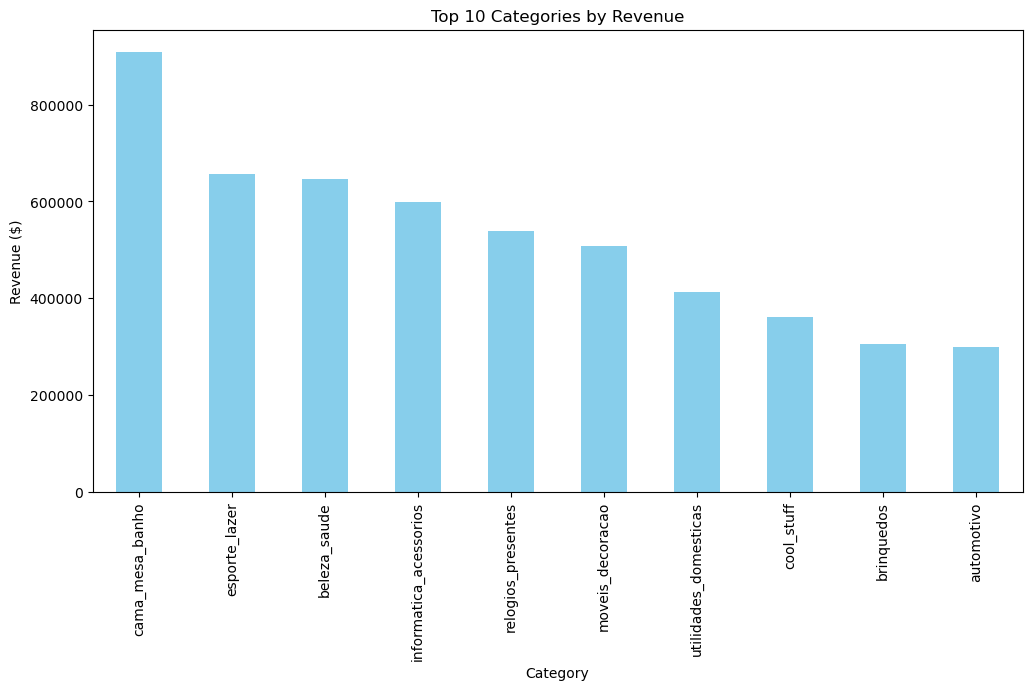

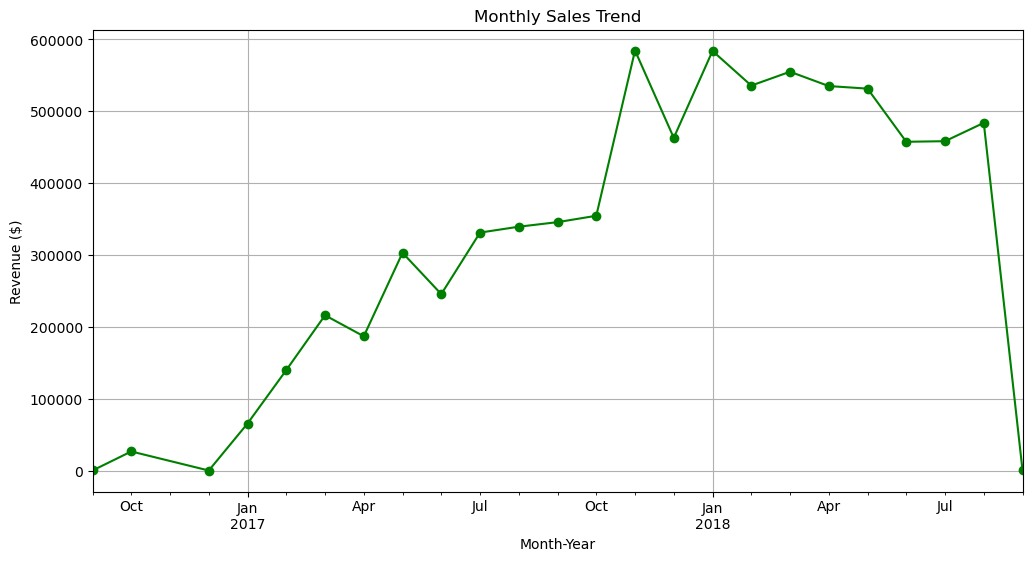

In [66]:
# Total Revenue
total_revenue = data['price'].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

# Revenue by Product Categories
category_revenue = data.groupby('product_category_name')['price'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
category_revenue.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Categories by Revenue')
plt.ylabel('Revenue ($)')
plt.xlabel('Category')
plt.show()

# Monthly Sales Trend
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['month_year'] = data['order_purchase_timestamp'].dt.to_period('M')
monthly_revenue = data.groupby('month_year')['price'].sum()
plt.figure(figsize=(12, 6))
monthly_revenue.plot(marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.ylabel('Revenue ($)')
plt.xlabel('Month-Year')
plt.grid()
plt.show()


In [67]:
# RFM Analysis
customer_data = data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': 'count',
    'price': 'sum'
}).reset_index()

# Calculate recency, frequency, and monetary values
customer_data['recency'] = (data['order_purchase_timestamp'].max() - customer_data['order_purchase_timestamp']).dt.days
customer_data.rename(columns={'order_id': 'frequency', 'price': 'monetary'}, inplace=True)

# RFM Scoring
rfm = customer_data.copy()

# Recency scoring
rfm['R'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])

# Frequency scoring - Handle duplicate bins
try:
    rfm['F'] = pd.qcut(rfm['frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    rfm['F'] = pd.cut(rfm['frequency'], bins=[0, 1, 2, 5, rfm['frequency'].max()], labels=[1, 2, 3, 4], include_lowest=True)

# Monetary scoring - Handle duplicate bins
try:
    rfm['M'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    rfm['M'] = pd.cut(rfm['monetary'], bins=[0, 100, 500, 1000, rfm['monetary'].max()], labels=[1, 2, 3, 4], include_lowest=True)

# Calculate RFM Score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Customer Segmentation
rfm['Segment'] = pd.cut(
    rfm['RFM_Score'],
    bins=[0, 6, 9, 12],
    labels=['Lost Customers', 'Regular Customers', 'Loyal Customers'],
    include_lowest=True
)

# View Segment Distribution
print(rfm['Segment'].value_counts())

# Additional insights (Optional)
# Average R, F, M per segment
segment_insights = rfm.groupby('Segment')[['recency', 'frequency', 'monetary']].mean().round(2)
print(segment_insights)


Segment
Lost Customers       46097
Regular Customers    30578
Loyal Customers       2385
Name: count, dtype: int64
                   recency  frequency  monetary
Segment                                        
Lost Customers      307.40       1.05     61.24
Regular Customers   161.41       1.35    138.94
Loyal Customers     101.21       3.46    279.95


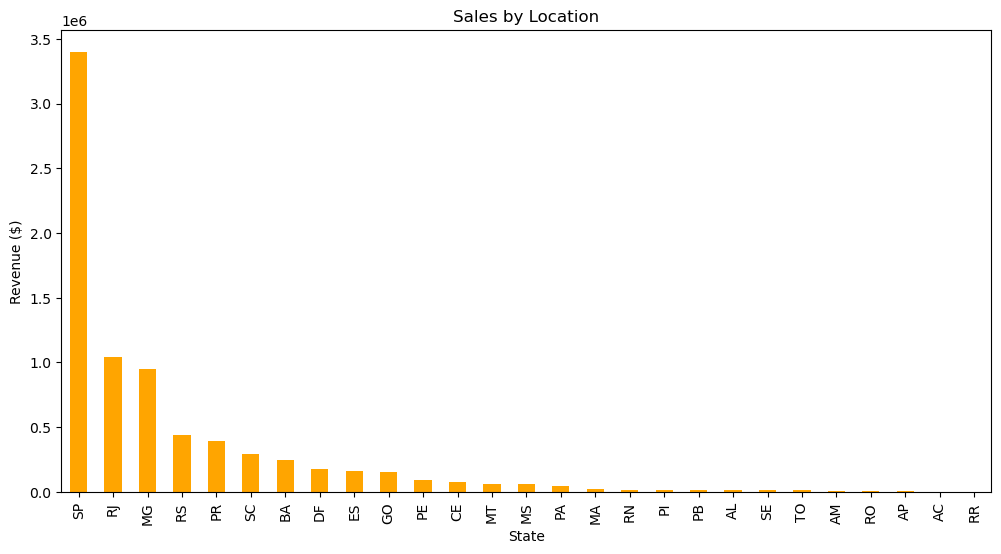

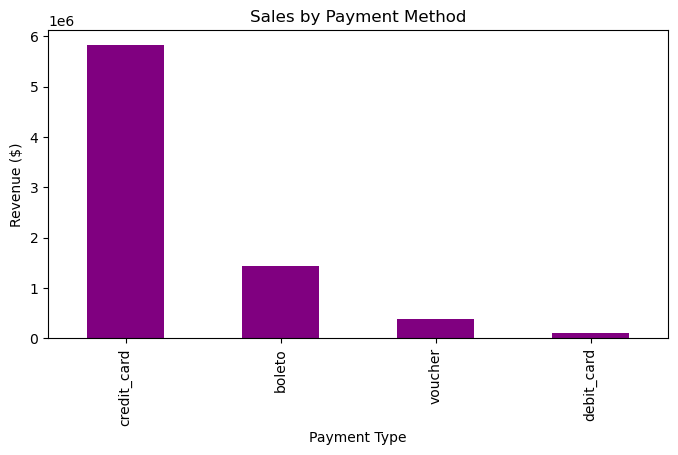

In [68]:
# Sales by Location
location_sales = data.groupby('customer_state')['price'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
location_sales.plot(kind='bar', color='orange')
plt.title('Sales by Location')
plt.ylabel('Revenue ($)')
plt.xlabel('State')
plt.show()

# Sales by Payment Method
payment_sales = data.groupby('payment_type')['price'].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
payment_sales.plot(kind='bar', color='purple')
plt.title('Sales by Payment Method')
plt.ylabel('Revenue ($)')
plt.xlabel('Payment Type')
plt.show()

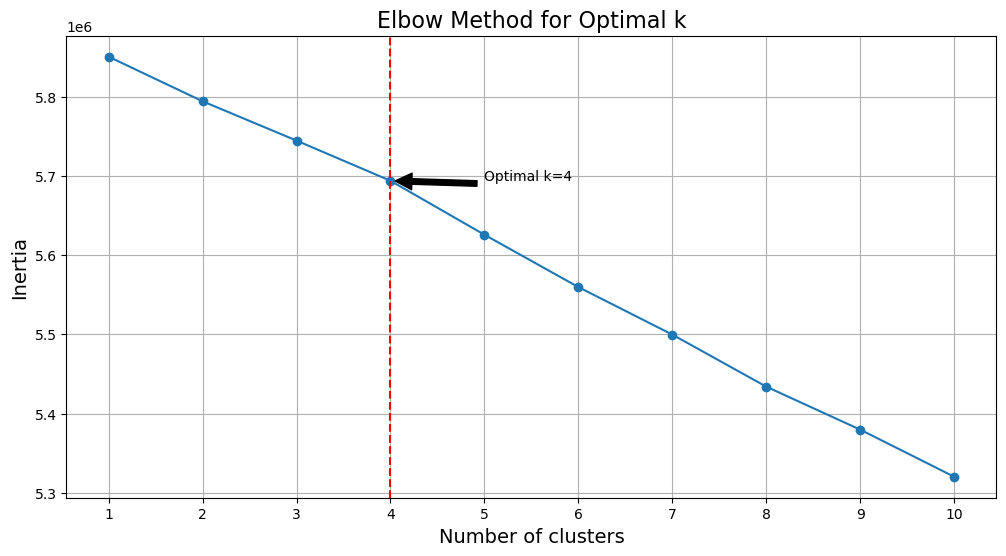

Average Spending per Product Category by Cluster:
Cluster                      0         1    2         3
product_category_name                                  
agro_industria_e_comercio  0.0  0.000000  0.0  0.097998
alimentos                  0.0  0.025513  0.0  0.366049
alimentos_bebidas          0.0  0.000000  0.0  0.194231
artes                      0.0  0.065742  0.0  0.216964
artes_e_artesanato         0.0  0.000000  0.0  0.017086
...                        ...       ...  ...       ...
tablets_impressao_imagem   0.0  0.000000  0.0  0.086635
telefonia                  0.0  0.000000  0.0  2.661768
telefonia_fixa             0.0  0.000000  0.0  0.219278
unknown                    0.0  0.195038  0.0  1.588493
utilidades_domesticas      0.0  0.961531  0.0  5.434586

[74 rows x 4 columns]


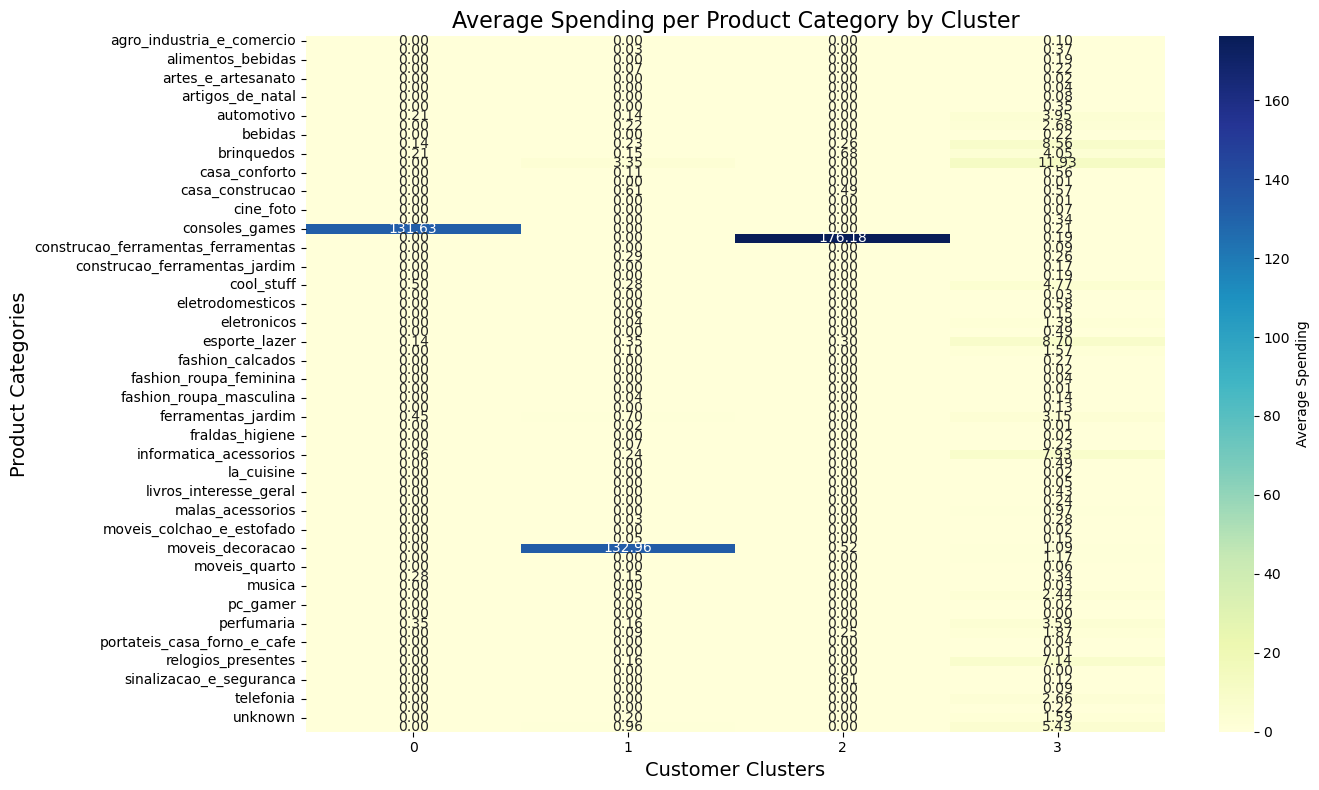


Cluster 0:
Number of Customers: 339
Average Spending in this Cluster: $1.81
Customers in this Cluster: ['01ffb8ddbd9e1167659827ed1b9b6ccf', '02220c4df207c6277c269f0b3a05c7cd', '02c661a1832c392b81d7ba1ebddf8796', '02fc5276df6dd1ff4901e5eb9efdbb92', '041eaf07c71e1d56b489dff63a270e6a', '042a39e49fdded8c64481a2accbabd44', '044ca7e46c0d89f6425f734864fb0212', '05669445931c028d97b7c0637b5a2359', '060d045d6d20b218921ded6f8ea42748', '0669bf2cb4551389e155f7daa3c1156e']

Cluster 1:
Number of Customers: 3194
Average Spending in this Cluster: $1.92
Customers in this Cluster: ['0036b4a3d09ad551a5188c2e374da402', '0037d2bbb9ebc39d9114aea27ee16d72', '0049db44bfd6cee26ac9c649329ff6ea', '0057f64bff87f4698b4cbd338d62a2a8', '0058e7db269cc11558913b42beb115d0', '007ad549acb91673f04eac22c0568114', '0096c9cb600a08e601f7c2be6734531a', '0097c1e3f3c2fed7a7d8cf30be1a33df', '0097fca0db567f5ca79509b7b4fc1c2d', '00b9746bf8ac2964942d8b969f015196']

Cluster 2:
Number of Customers: 230
Average Spending in this Cluster

In [69]:
# Prepare Data for Market Basket Analysis
basket = data.groupby(['customer_unique_id', 'product_category_name'])['price'].sum().unstack().fillna(0)

# Step 2: Normalize the Data
scaler = StandardScaler()
basket_normalized = scaler.fit_transform(basket)

# Step 3: Apply K-means Clustering
# Determine the optimal number of clusters using the Elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(basket_normalized)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow method
plt.figure(figsize=(12, 6))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(K)
plt.grid()
plt.axvline(x=4, linestyle='--', color='red')  # Example line to show the chosen k
plt.annotate('Optimal k=4', xy=(4, inertia[3]), xytext=(5, inertia[3] + 50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Based on the Elbow plot, choose an optimal number of clusters (e.g., 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
basket['Cluster'] = kmeans.fit_predict(basket_normalized)

# Step 4: Analyze the Clusters
cluster_analysis = basket.groupby('Cluster').mean().T

# Print average spending per product category by cluster
print("Average Spending per Product Category by Cluster:")
print(cluster_analysis)

# Plot average spending per product category by cluster
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_analysis, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Spending'})
plt.title('Average Spending per Product Category by Cluster', fontsize=16)
plt.xlabel('Customer Clusters', fontsize=14)
plt.ylabel('Product Categories', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 5: Identify customers in each cluster and print insights
for cluster in range(optimal_k):
    cluster_customers = basket[basket['Cluster'] == cluster].index.tolist()
    avg_spending = cluster_analysis.iloc[:, cluster].mean()
    
    print(f"\nCluster {cluster}:")
    print(f"Number of Customers: {len(cluster_customers)}")
    print(f"Average Spending in this Cluster: ${avg_spending:.2f}")
    print(f"Customers in this Cluster: {cluster_customers[:10]}")  # Print first 10 customers for brevity


Time Series Data:
order_purchase_timestamp
2016-09-01        59.50
2016-10-01     26524.66
2016-12-01        10.90
2017-01-01     65405.67
2017-02-01    139702.63
Name: price, dtype: float64
Forecasted Values:
2018-10-31     42149.305993
2018-11-30    243373.160504
2018-12-31    115279.710911
2019-01-31    217233.093079
2019-02-28    164375.900330
2019-03-31    188627.570266
2019-04-30    102278.448974
2019-05-31    173013.777088
2019-06-30     77007.997311
2019-07-31    119038.104299
2019-08-31     93165.611476
2019-09-30     66272.473231
Freq: M, dtype: float64


/Users/chitransh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chitransh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/chitransh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chitransh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


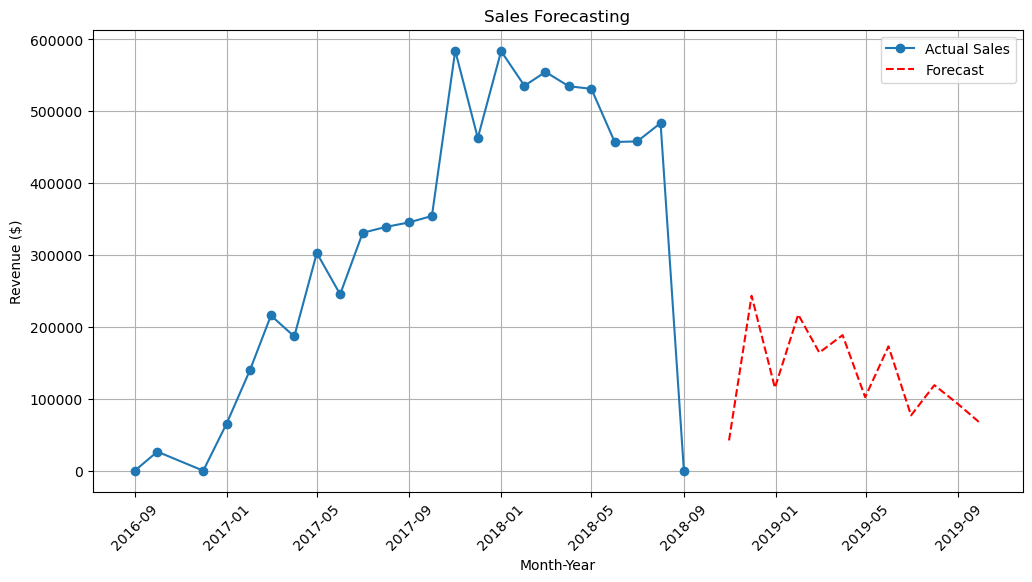

In [70]:
# Sales Forecasting

# Ensure the order_purchase_timestamp is in datetime format
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce')

# Check for NaT values after conversion
if data['order_purchase_timestamp'].isnull().any():
    print("Warning: Some dates could not be parsed, resulting in NaT values.")

# Time-Series Data: Grouping by Month and summing the sales price
time_series = data.groupby(data['order_purchase_timestamp'].dt.to_period('M'))['price'].sum()

# Convert PeriodIndex to TimestampIndex
time_series.index = time_series.index.to_timestamp()

# Print the first few rows of the time series for debugging
print("Time Series Data:")
print(time_series.head())

# Model: Applying Exponential Smoothing
model = ExponentialSmoothing(time_series, seasonal='add', seasonal_periods=12).fit()

# Forecasting for the next 12 periods
forecast = model.forecast(12)

# Create a new date index for the forecast
forecast_index = pd.date_range(start=time_series.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Assign the new index to the forecast
forecast.index = forecast_index

# Print forecast values for debugging
print("Forecasted Values:")
print(forecast)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Actual Sales', marker='o')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.title('Sales Forecasting')
plt.ylabel('Revenue ($)')
plt.xlabel('Month-Year')
plt.xticks(rotation=45)  # Rotate x-tick labels for better readability
plt.legend()
plt.grid()
plt.show()


Checking for non-numeric values in the features...
freight_value                 float64
product_photos_qty             object
product_weight_g              float64
price                         float64
payment_sequential              int64
payment_installments            int64
payment_value                 float64
review_score                    int64
product_name_length            object
product_description_length     object
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
delivery_time                   int64
dtype: object
Coefficients:
                       Feature  Coefficient
0                freight_value     1.545023
1           product_photos_qty     0.341137
2             product_weight_g     0.003040
3           payment_sequential     2.828499
4         payment_installments     2.421358
5                payment_value     0.218874
6                 review_score     3.142664
7          product_name_length     0.

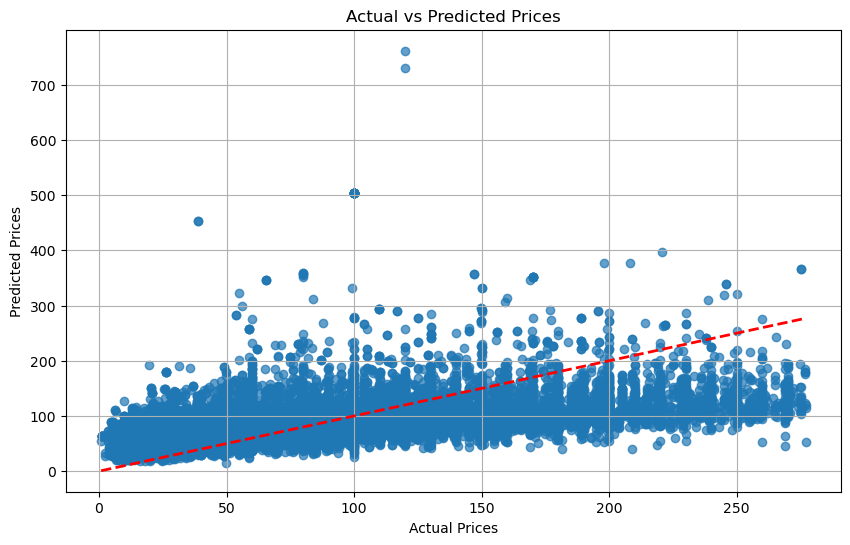

In [71]:
# Regression Analysis for Influencing Factors

# Step 1: Check for non-numeric values in the features
print("Checking for non-numeric values in the features...")
print(data[['freight_value', 'product_photos_qty', 'product_weight_g', 'price',
            'payment_sequential', 'payment_installments', 'payment_value',
            'review_score', 'product_name_length', 'product_description_length',
            'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time']].dtypes)

# Step 2: Replace 'unknown' and other non-numeric values with NaN
data.replace('unknown', np.nan, inplace=True)

# Step 3: Convert columns to numeric, forcing errors to NaN
numeric_columns = [
    'freight_value', 'product_photos_qty', 'product_weight_g', 'price', 
    'payment_sequential', 'payment_installments', 'payment_value', 
    'review_score', 'product_name_length', 'product_description_length', 
    'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time'
]

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Step 4: Drop rows with NaN values in the features
data.dropna(subset=numeric_columns, inplace=True)

# Features and Target
X = data[[col for col in numeric_columns if col != 'price']]
y = data['price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model
model = LinearRegression().fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("Coefficients:")
print(coefficients)

# Evaluation Metrics
print(f'\nMean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Visualization of Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid()
plt.show()


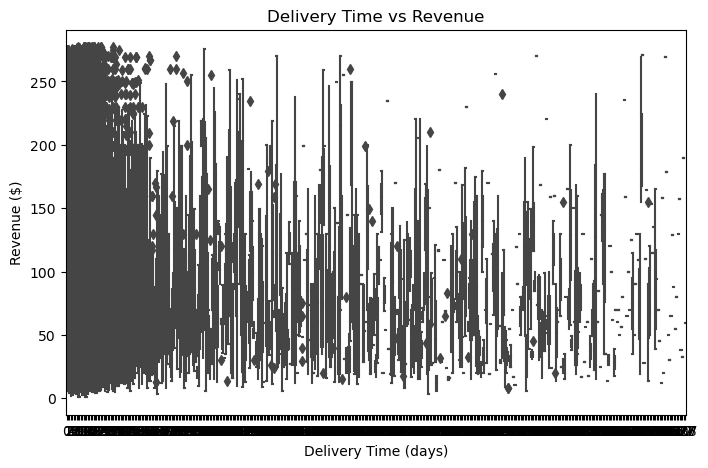

Delivery Time vs Revenue Statistics:
                count        mean        std     min     25%     50%     75%  \
delivery_time                                                                  
0               713.0   83.340561  60.373549    6.04   36.49   68.31  114.90   
1              1733.0   69.704033  56.372381    6.30   29.90   49.90   91.55   
2              3528.0   69.936477  53.959611    4.30   29.00   50.45   98.00   
3              4069.0   72.247891  54.578664    2.20   29.90   55.50   99.90   
4              5209.0   72.679581  54.731457    2.29   29.99   55.90   99.00   
...               ...         ...        ...     ...     ...     ...     ...   
617               1.0  156.970000        NaN  156.97  156.97  156.97  156.97   
627               4.0   38.000000   0.000000   38.00   38.00   38.00   38.00   
677               1.0   32.500000        NaN   32.50   32.50   32.50   32.50   
678               1.0  189.900000        NaN  189.90  189.90  189.90  189.90   
707

In [72]:
# Boxplot of Delivery Time vs Revenue
plt.figure(figsize=(8, 5))
sns.boxplot(x='delivery_time', y='price', data=data)
plt.title('Delivery Time vs Revenue')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Revenue ($)')
plt.show()

# Print basic statistics for revenue based on delivery time
delivery_time_stats = data.groupby('delivery_time')['price'].describe()
print("Delivery Time vs Revenue Statistics:")
print(delivery_time_stats)

# Additional Observations
for delivery_time in data['delivery_time'].unique():
    revenue_data = data[data['delivery_time'] == delivery_time]['price']
    median_revenue = revenue_data.median()
    mean_revenue = revenue_data.mean()
    print(f"\nDelivery Time: {delivery_time} days")
    print(f"  - Median Revenue: ${median_revenue:.2f}")
    print(f"  - Mean Revenue: ${mean_revenue:.2f}")
    print(f"  - Count of Orders: {len(revenue_data)}")
